In [1]:
#3 factor model with prv - error of prv and rv

In [2]:
#interpretation? see bottom
#general problem: dependance of n, might have rank 8-9 for n=180 and all other like in optimal setup...
                #but for L=30 it got good again, a bit random...?

In [3]:
#packages

import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

from scipy.linalg import sqrtm
from scipy.stats import gaussian_kde

print("ok")

ok


In [4]:
#control of process

#save image
save_image=0       # 1 = yes, 0 = no

#dealing with negative sigma^2
deal_neg_sigma_square=1     # 1= abs , 2= max(0,)

#cholesky decomposition
rho_matrix_sq_root=0     #0=cholesky (triangular matrix) , 1=sqrt matrix

#initialization of processes gamma and sigma:
init_gamma=3   #0=with zeros, 1= with mean , 2= normal, 3=with mean/2
init_sigma=0   #0=with zeros, 1= with mean , 2= normal

#factor before lambda
factor_lambda=1     #scale lambdas by factor

In [5]:
#first parameters
T=1
n=78
delta_n=T/n
t=np.linspace(0,T,n+1)

d=30
r=3

#number paths see later...


#Z
#values divided by:
div=1

kappa_Z=4/div
theta_Z=0.25/div
eta_Z=0.06/div

#sigma_square
kappa=np.array([3,4,5])
theta=np.array([0.05,0.04,0.03])
eta=np.array([0.3,0.4,0.3])
rho=np.array([-0.6,-0.4,-0.25])

#F
alpha=np.array([0.05,0.03,0.02])
L_L_T=np.array([[1,0.05,0.1],[0.05,1,0.15],[0.1,0.15,1]])
if rho_matrix_sq_root==0:
    L=np.linalg.cholesky(L_L_T)
elif rho_matrix_sq_root==1:
    L=sqrtm(L_L_T)
#print(L@L.T)

#Y
beta_market_lower=0.25
beta_market_upper=1.75
beta_normal_std=0.5
beta_normal_exp=0

#data driven lambda
L_lambda=6 #divides n!


print("ok")

ok


In [6]:
#many paths

number_paths=1000
monte_carlo_of_eigenvalues_normed=np.zeros((number_paths, d))
monte_carlo_lambdas=np.zeros(number_paths)
normed_monte_carlo_lambdas=np.zeros(number_paths) #normed by largest eigenvalue of rv
rank_prv_monte_carlo=np.zeros(number_paths)

squared_frobenius_estimation_error_rv_monte_carlo=np.zeros(number_paths)
squared_frobenius_estimation_error_prv_monte_carlo=np.zeros(number_paths)
nuclear_estimation_error_rv_monte_carlo=np.zeros(number_paths)
nuclear_estimation_error_prv_monte_carlo=np.zeros(number_paths)

only_factors_squared_frobenius_estimation_error_rv_monte_carlo=np.zeros(number_paths)
only_factors_squared_frobenius_estimation_error_prv_monte_carlo=np.zeros(number_paths)
only_factors_nuclear_estimation_error_rv_monte_carlo=np.zeros(number_paths)
only_factors_nuclear_estimation_error_prv_monte_carlo=np.zeros(number_paths)


for j in range(number_paths):
    #paths simulated

    #objects

    #gamma
    gamma_square_t_j=np.zeros((n+1,d))
    if init_gamma==1:
        gamma_square_t_j[0,:]=theta_Z*np.ones(d)
    elif init_gamma==2:
        gamma_square_t_j[0,:]=np.abs(np.random.normal(theta_Z, beta_normal_std, (1,d))) #bad results, rather rank 1,2
    elif init_gamma==3:
        gamma_square_t_j[0,:]=theta_Z/2*np.ones(d)

    dB_tilde=np.sqrt(delta_n)*np.random.randn(n,d)

    #Z
    dB=np.sqrt(delta_n)*np.random.randn(n,d)
    delta_Z_t=np.zeros((n,d))

    #sigma-square
    dW=np.sqrt(delta_n)*np.random.randn(n,r)
    dW_tilde=np.sqrt(delta_n)*np.random.randn(n,r)
    sigma_square=np.zeros((n+1,r))
    if init_sigma==1:
        sigma_square[0,:]=theta*np.ones(r)
    elif init_sigma==2:
        sigma_square[0,:]=np.abs(theta+np.random.normal(0, beta_normal_std, (1,r))) #bad results, rather rank 1,2

    #F
    delta_F=np.zeros((n,r))

    #Y
    beta=np.zeros((d,r))
    beta[:,0]=np.random.uniform(beta_market_lower, beta_market_upper, d)
    beta[:,1:]=np.random.normal(beta_normal_exp, beta_normal_std, (d,(r-1)))

    delta_Y=np.zeros((n,d))
    
    #c_t
    integrated_c_t=np.zeros((d,d))
    only_factors_integrated_c_t=np.zeros((d,d))


    #simulation of paths with Euler-Maruyama
    for i in range(n):
        gamma_square_t_j[i+1,:]=(gamma_square_t_j[i,:]+kappa_Z*(theta_Z*np.ones(d)-gamma_square_t_j[i,:])*delta_n
                            + eta_Z*np.sqrt(gamma_square_t_j[i,:])*dB_tilde[i,:])

        delta_Z_t[i,:]=np.sqrt(gamma_square_t_j[i,:])*dB[i,:]

        
        
        if deal_neg_sigma_square==2: 
            #attention, here sometimes error,'RuntimeWarning: invalid value encountered in sqrt', wenn sigma_square kleiner null wird!
            #solution: max with 0
            sigma_square[i+1,:]=np.maximum((sigma_square[i,:]+kappa*(theta-sigma_square[i,:])*delta_n
                                 +eta*np.sqrt(sigma_square[i,:])*(rho*dW[i,:]+np.sqrt(np.ones(r)-np.square(rho))*dW_tilde[i,:])), 
                                np.zeros(r))
        elif deal_neg_sigma_square==1:
            #solution abs
            sigma_square[i+1,:]=np.abs((sigma_square[i,:]+kappa*(theta-sigma_square[i,:])*delta_n
                                 +eta*np.sqrt(sigma_square[i,:])*(rho*dW[i,:]+np.sqrt(np.ones(r)-np.square(rho))*dW_tilde[i,:])))
        else:
            #errors
            sigma_square[i+1,:]=(sigma_square[i,:]+kappa*(theta-sigma_square[i,:])*delta_n
                                 +eta*np.sqrt(sigma_square[i,:])*(rho*dW[i,:]+np.sqrt(np.ones(r)-np.square(rho))*dW_tilde[i,:]))

            
            
        delta_F[i,:]=delta_n*alpha+(np.diag(np.sqrt(sigma_square[i,:]))@L@(dW[i,:].reshape(r,1))).T

        delta_Y[i,:]=(beta@(delta_F[i,:].reshape(r,1))).T+delta_Z_t[i,:]
        
        
        #sigma estimation
        integrated_c_t+=delta_n*(beta@np.diag(np.sqrt(sigma_square[i,:]))@L_L_T@np.diag(np.sqrt(sigma_square[i,:]))@beta.T
                                 +np.diag(gamma_square_t_j[i,:]))
        only_factors_integrated_c_t+=delta_n*(beta@np.diag(np.sqrt(sigma_square[i,:]))@L_L_T@np.diag(np.sqrt(sigma_square[i,:]))@beta.T)



    #calculation of realized variance
    sigma_hat_n_rv=np.zeros((d,d))
    for i in range(n):
        sigma_hat_n_rv+= (delta_Y[i,:].reshape(1,d).T) @ delta_Y[i,:].reshape(1,d)    

    #eigenvalues
    eigenvalues_rv=(np.linalg.eigvalsh(sigma_hat_n_rv))[::-1]    #decreasing order now
    eigenvalues_rv_normed=eigenvalues_rv/np.sum(eigenvalues_rv)
    monte_carlo_of_eigenvalues_normed[j,:]=eigenvalues_rv_normed

    #subsampling for choice of lambda
    lambdas=np.zeros(L_lambda)
    for l in range(L_lambda):
        
        delta_Y_subsample=delta_Y[np.arange(l,n,L_lambda),:]
        subsamp_sigma_hat_n_rv=np.zeros((d,d))
        
        for k in range(delta_Y_subsample.shape[0]):
            subsamp_sigma_hat_n_rv+= (L_lambda/n)*(np.sqrt(n)*delta_Y_subsample[k,:].reshape(1,d).T) @ (np.sqrt(n)*delta_Y_subsample[k,:].reshape(1,d)) 
            
        lambdas[l]=(2/np.sqrt(L_lambda))*np.linalg.norm((subsamp_sigma_hat_n_rv - sigma_hat_n_rv), ord=2) #spectral norm here order 2
       
    lambda_final=np.mean(lambdas)*factor_lambda #attention, here factor
    monte_carlo_lambdas[j]=lambda_final
    normed_monte_carlo_lambdas[j]=monte_carlo_lambdas[j]/eigenvalues_rv[0]
    
    #prv calculation (with Theorem 3.6 in the thesis)
    sigma_hat_n_lambda_prv=np.zeros((d,d))
    Sigma_ascending, U = np.linalg.eigh(sigma_hat_n_rv)
    #Sigma=Sigma_ascending[::-1]
    #for z in range(d):
        #if Sigma[z]>(lambda_final/2):
            #sigma_hat_n_lambda_prv+=(Sigma[z]-(lambda_final/2))* ((U[:,d-z-1].reshape(d,1)) @ (U[:,d-z-1].reshape(d,1).T))
            ##attention: since eigenvalues in Sigma are flipped in order, the index of U is d-z-1 insetad of z!
        #else:
            ##as descending, all others are also samller (lambda_final/2)
            #rank_prv_monte_carlo[j]=z
            #break 
    for z in range(d):
        if Sigma_ascending[d-z-1]>(lambda_final/2):
            sigma_hat_n_lambda_prv+=(Sigma_ascending[d-z-1]-(lambda_final/2))* ((U[:,d-z-1].reshape(d,1)) @ (U[:,d-z-1].reshape(d,1).T))
            #attention: since eigenvalues in Sigma are flipped in order, the index of U is d-z-1 insetad of z!
        else:
            #as descending, all others are also samller (lambda_final/2)
            rank_prv_monte_carlo[j]=z
            break 
    
    #error estimation
    squared_frobenius_estimation_error_rv_monte_carlo[j]=np.linalg.norm(sigma_hat_n_rv-integrated_c_t,'fro')**2
    squared_frobenius_estimation_error_prv_monte_carlo[j]=np.linalg.norm(sigma_hat_n_lambda_prv-integrated_c_t,'fro')**2
    nuclear_estimation_error_rv_monte_carlo[j]=np.linalg.svd(sigma_hat_n_rv-integrated_c_t, compute_uv=False, hermitian =True).sum()
    nuclear_estimation_error_prv_monte_carlo[j]=np.linalg.svd(sigma_hat_n_lambda_prv-integrated_c_t, compute_uv=False, hermitian =True).sum()
    
    only_factors_squared_frobenius_estimation_error_rv_monte_carlo[j]=np.linalg.norm(sigma_hat_n_rv-only_factors_integrated_c_t,'fro')**2
    only_factors_squared_frobenius_estimation_error_prv_monte_carlo[j]=np.linalg.norm(sigma_hat_n_lambda_prv-only_factors_integrated_c_t,'fro')**2
    only_factors_nuclear_estimation_error_rv_monte_carlo[j]=np.linalg.svd(sigma_hat_n_rv-only_factors_integrated_c_t, compute_uv=False, hermitian =True).sum()
    only_factors_nuclear_estimation_error_prv_monte_carlo[j]=np.linalg.svd(sigma_hat_n_lambda_prv-only_factors_integrated_c_t, compute_uv=False, hermitian =True).sum()
    
    if j% 500==0:
        print(f"ok,j={j}.")
    
    

ok,j=0.
ok,j=500.


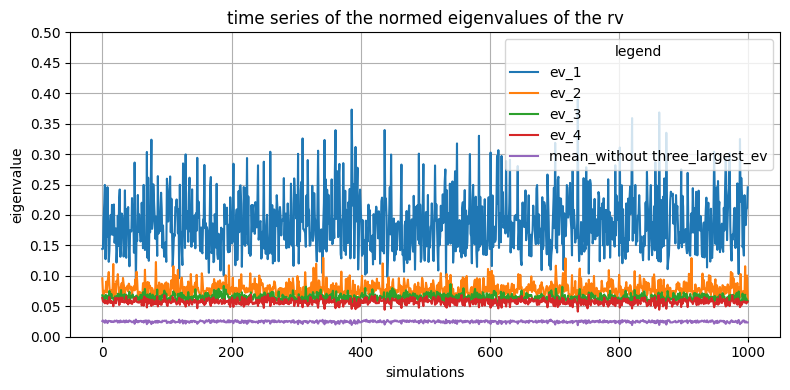

In [7]:
#plot eigenvalues-normed
normed_eigenvalue_mean_without_three_largest=np.mean(monte_carlo_of_eigenvalues_normed[:, 3:], axis=1)

plt.figure(figsize=(8, 4))
plt.plot(monte_carlo_of_eigenvalues_normed[:, 0], label='ev_1')
plt.plot(monte_carlo_of_eigenvalues_normed[:, 1], label='ev_2')
plt.plot(monte_carlo_of_eigenvalues_normed[:, 2], label='ev_3')
plt.plot(monte_carlo_of_eigenvalues_normed[:, 3], label='ev_4')
plt.plot(normed_eigenvalue_mean_without_three_largest, label='mean_without three_largest_ev')

plt.yticks(np.arange(0,0.55,0.05))

plt.title('time series of the normed eigenvalues of the rv')
plt.xlabel('simulations')
plt.ylabel('eigenvalue')
plt.legend(loc='upper right', title='legend')
plt.grid(True)
plt.tight_layout()

if save_image==1:
    plt.savefig("plot_1_ev_paths_rv___n_78___abs_in_sigma___zero_start_values_sigma____half_mean_gamma___Cholesky_1.png", dpi=300, bbox_inches="tight") 
    #high resolution dpi, cut of edge bbox

plt.show()
plt.close()


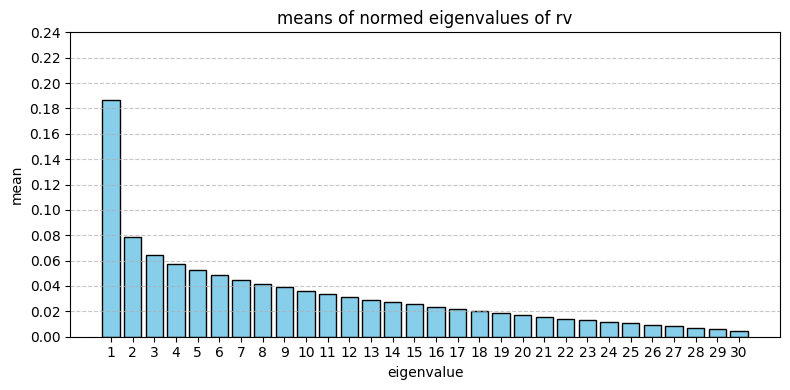

In [8]:
#plot of means

# Compute mean of each column
normed_eigenvalue_means = np.mean(monte_carlo_of_eigenvalues_normed, axis=0)

cols= np.arange(1, d+1)
#plot
plt.figure(figsize=(8, 4))
plt.bar(cols, normed_eigenvalue_means, color='skyblue', edgecolor='black')
plt.xlabel('eigenvalue')
plt.ylabel('mean')
plt.title('means of normed eigenvalues of rv')
plt.xticks(cols) #ticks at the columns
plt.yticks(np.arange(0,0.25,0.02))

plt.grid(axis='y', linestyle='--', alpha=0.7) #only horizontal lines 
plt.tight_layout()

if save_image==1:
    plt.savefig("plot_2_means_ev_rv___n_78___abs_in_sigma___zero_start_values_sigma____half_mean_gamma___Cholesky_1.png", dpi=300, bbox_inches="tight") 
    #high resolution dpi, cut of edge bbox

plt.show()
plt.close()

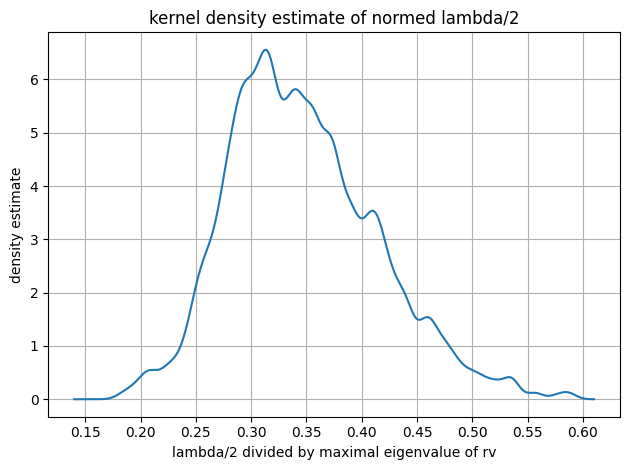

In [9]:
#kernel density estimation of lambda

kde = gaussian_kde(normed_monte_carlo_lambdas/2, bw_method=0.1) #bw_method controls smoothing
x = np.linspace(0.14, 0.61, 1000)
plt.plot(x, kde(x))
plt.title("kernel density estimate of normed lambda/2")
plt.xlabel('lambda/2 divided by maximal eigenvalue of rv')
plt.ylabel('density estimate')

plt.xticks(np.arange(0.15,0.65,0.05))

plt.grid(True)
plt.tight_layout()

if save_image==1:
    plt.savefig("plot_3_lambda_kde___n_78___L_6___factor_1___abs_in_sigma___zero_start_values_sigma____half_mean_gamma___Cholesky_1.png", dpi=300, bbox_inches="tight") 
    #high resolution dpi, cut of edge bbox

plt.show()
plt.close()


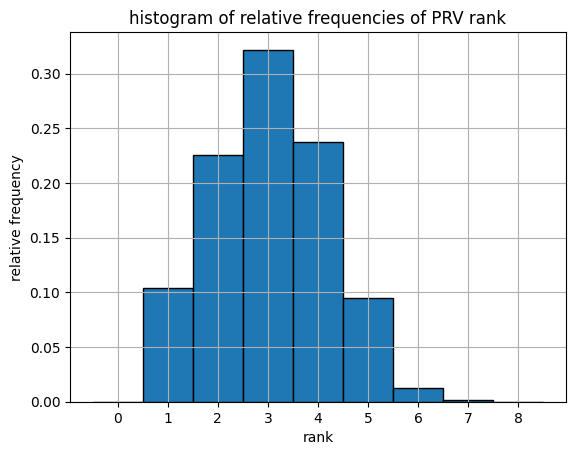

In [10]:
#rank of prv

bins_def = np.arange(0, np.max(rank_prv_monte_carlo) + 3) - 0.5                    #bin edges:-0.5,0.5,...,max_rank+2-0.5
plt.hist(rank_prv_monte_carlo, bins=bins_def, density=True, edgecolor='black')     #density for relative
plt.xticks(np.arange(0,np.max(rank_prv_monte_carlo) + 2))
plt.title("histogram of relative frequencies of PRV rank")
plt.xlabel("rank")
plt.ylabel("relative frequency")
plt.grid(True)

if save_image==1:
    plt.savefig("plot_4_rank_prv___n_78___L_6___factor_1___abs_in_sigma___zero_start_values_sigma____half_mean_gamma___Cholesky_1.png", dpi=300, bbox_inches="tight") 
    #high resolution dpi, cut of edge bbox

plt.show()
plt.close()


In [11]:
#plot estimation errors

plt.figure(figsize=(8, 4))
plt.plot(squared_frobenius_estimation_error_rv_monte_carlo, label='Frobenius norm^2 rv error')
plt.plot(squared_frobenius_estimation_error_prv_monte_carlo, label='Frobenius norm^2 prv error')
plt.plot(nuclear_estimation_error_rv_monte_carlo, label='nuclear norm rv error')
plt.plot(nuclear_estimation_error_prv_monte_carlo, label='nuclear norm prv error')

plt.title('time series of the estimation errors')
plt.xlabel('simulations')
plt.ylabel('errors')
plt.ylim(0,15)
plt.legend(loc='upper right', title='legend')
plt.grid(True)
plt.tight_layout()

#if save_image==1:
    #plt.savefig("plot_est_errors___abs_in_sigma___zero_start_values_sigma____half_mean_gamma___Cholesky_1.png", dpi=300, bbox_inches="tight") 
    #high resolution dpi, cut of edge bbox

#plt.show()
plt.close()


In [12]:
#plot estimation errors for sigma induced by factors

plt.figure(figsize=(8, 4))
plt.plot(only_factors_squared_frobenius_estimation_error_rv_monte_carlo, label='Frobenius norm^2 rv error')
plt.plot(only_factors_squared_frobenius_estimation_error_prv_monte_carlo, label='Frobenius norm^2 prv error')
plt.plot(only_factors_nuclear_estimation_error_rv_monte_carlo, label='nuclear norm rv error')
plt.plot(only_factors_nuclear_estimation_error_prv_monte_carlo, label='nuclear norm prv error')

plt.title('time series of the estimation errors of sigma induced by the factors')
plt.xlabel('simulations')
plt.ylabel('errors')
plt.ylim(0,15)
plt.legend(loc='upper right', title='legend')
plt.grid(True)
plt.tight_layout()

#if save_image==1:
    #plt.savefig("plot_est_errors_only_factors___abs_in_sigma___zero_start_values_sigma____half_mean_gamma___Cholesky_1.png", dpi=300, bbox_inches="tight") 
    #high resolution dpi, cut of edge bbox

#plt.show()
plt.close()

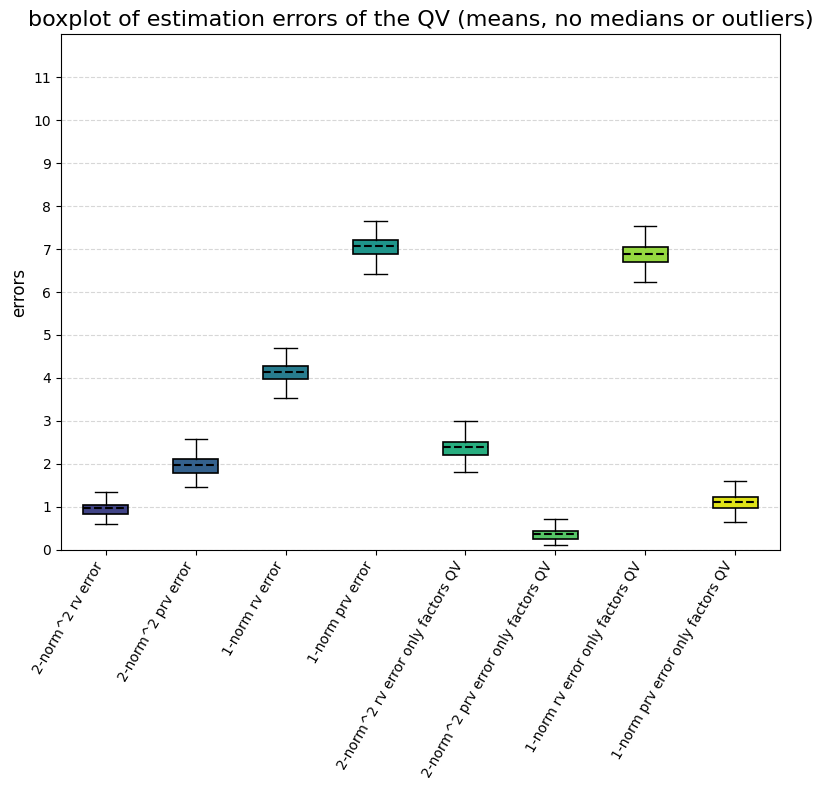

In [13]:
#boxplots of the errors

data=[squared_frobenius_estimation_error_rv_monte_carlo, squared_frobenius_estimation_error_prv_monte_carlo,
      nuclear_estimation_error_rv_monte_carlo, nuclear_estimation_error_prv_monte_carlo,
      only_factors_squared_frobenius_estimation_error_rv_monte_carlo, only_factors_squared_frobenius_estimation_error_prv_monte_carlo,
      only_factors_nuclear_estimation_error_rv_monte_carlo, only_factors_nuclear_estimation_error_prv_monte_carlo]

labels=["2-norm^2 rv error", "2-norm^2 prv error",
        "1-norm rv error", "1-norm prv error",
        "2-norm^2 rv error only factors QV", "2-norm^2 prv error only factors QV",
        "1-norm rv error only factors QV", "1-norm prv error only factors QV"]

colors = plt.cm.viridis(np.linspace(0.2, 0.95, len(data))) # len(data) evenly spaced numbers

plt.figure(figsize=(8, 8))

# create boxplot
box = plt.boxplot(
    data,
    patch_artist=True, #colors for boxes  
    notch=False, #no notches
    showmeans=True, #means
    meanline=True, #as lines
    showfliers=False #no outliers
)

#apply colors
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_edgecolor('black')
    patch.set_linewidth(1.2)

#means
for mean in box['means']:
    mean.set(color='black', linewidth=1.5)

#no medians    
for median in box['medians']:
    median.set_visible(False)

# x-axis
plt.xticks(
    ticks=range(1, len(data)+1),
    labels=labels,
    rotation=60,
    ha='right' #labels to the right of tick
)

plt.yticks(np.arange(0,12,1))

plt.grid(axis='y', linestyle='--', alpha=0.5) #alpha for transparency
plt.ylabel("errors", fontsize=12)
plt.ylim(0,12)
plt.title("boxplot of estimation errors of the QV (means, no medians or outliers)", fontsize=16)

plt.tight_layout()
if save_image==1:
    plt.savefig("boxplot_est_errors___n_78___abs_in_sigma___zero_start_values_sigma____half_mean_gamma___Cholesky_1.png", dpi=300, bbox_inches="tight") 
    #high resolution dpi, cut of edge bbox

plt.show()
plt.close()

In [14]:
#interpretation:
#old:
#rv in general smaller norms, but if only factors influence is taken: 
#prv better nuclear norm, also better rank (rv always rank 30, prv in 1-5 mostly)
#interesting: prv always more variance in estimation error

#new: now if only factors: better result for prv, outperforms rv...